## 桃子分类

使用桃子分类数据集，基于PaddleHub对ImageNet数据集上的预训练模型Resnet50进行Fine-tune，得到一个桃子分类模型。

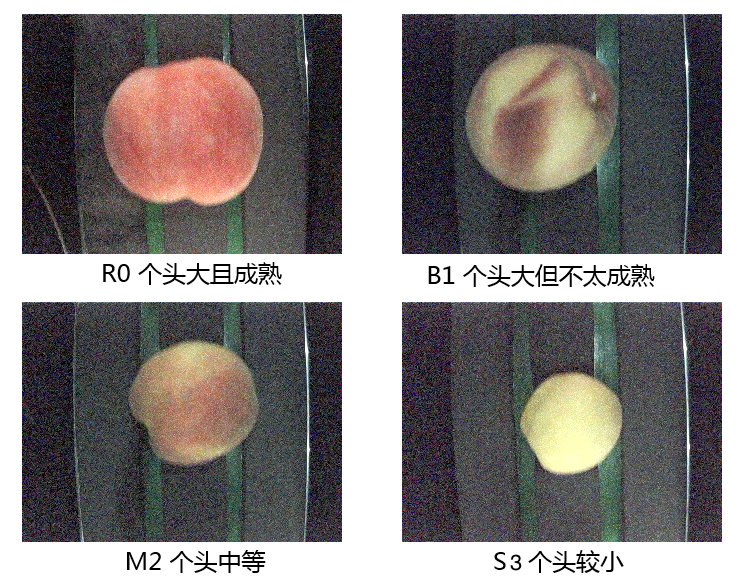

### 安装并加载预训练模型库

In [2]:
import paddle
import paddlehub as hub
import paddlehub.vision.transforms as T
from paddlehub.finetune.trainer import Trainer

import numpy as np
import os

### 数据准备

利用PaddleHub迁移CV类任务使用自定义数据集，需要自行切分数据集：训练集、验证集、测试集（通常为6:2:2），需要三个文本文件来记录对应的图片路径和标签，还需要一个标签文件来记录标签的名称。

data 数据目录
- train_list.txt 训练集数据列表
- validate_list.txt 验证集数据列表
- test_list.txt 测试集数据列表
- label_list.txt 标签列表

数据列表格式如下，列与列之间以空格分隔：
```
图片1路径 图片1标签
图片2路径 图片2标签
```

标签列表格式：
```
分类1名称
分类2名称
```

In [3]:
# 构建数据读取器
class PeachDataset(paddle.io.Dataset):
    def __init__(self, transforms, num_classes=4, mode='train'):
        super(PeachDataset, self).__init__()
        
        self.transforms = transforms
        self.num_classes = num_classes
        self.mode = mode
        
        self.dataset_dir = '../datasets/peach-classification'  # 数据集存放路径
        if self.mode == 'train':
            self.file = 'train_list.txt'
        elif self.mode == 'test':
            self.file = 'test_list.txt'
        else:
            self.file = 'validate_list.txt'
        self.file = os.path.join(self.dataset_dir, self.file)
        
        with open(self.file, 'r', encoding='utf-8') as f:
            self.data = f.read().split('\n')[:-1]
        
    def __getitem__(self, idx):
        img_path, label = self.data[idx].split(' ')
        img_path = os.path.join(self.dataset_dir, img_path)
        img = self.transforms(img_path)
        return img, int(label)
    
    def __len__(self):
        return len(self.data)

In [4]:
# 在将数据输入模型之前，通常还需要对原始数据做一些数据处理工作，比如数据格式规范化处理、增加数据增强策略等
transforms = T.Compose([
    T.Resize((256, 256)),  # 将所有样本数据统一成指定尺寸
    T.CenterCrop(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 将所有图像数据进行归一化处理
], to_rgb=True)

In [5]:
# 训练集
train_dataset = PeachDataset(transforms)

# 验证集
val_dataset = PeachDataset(transforms, mode='val')

type(train_dataset)

__main__.PeachDataset

### 模型选择

针对该图像分类任务，选择在ImageNet数据集上训练过的Resnet50模型，50层是一个精度和性能兼顾的选择。

In [6]:
model = hub.Module(name='resnet50_vd_imagenet_ssld', label_list=['R0', 'B1', 'M2', 'S3'])

Download https://bj.bcebos.com/paddlehub/paddlehub_dev/resnet50_vd_imagenet_ssld.tar.gz
[##################################################] 100.00%
Decompress /Users/neowong/.paddlehub/tmp/tmpvt7lxc0k/resnet50_vd_imagenet_ssld.tar.gz
[##################################################] 100.00%


[2022-12-19 13:42:33,078] [    INFO] - Successfully installed resnet50_vd_imagenet_ssld-1.1.0


load pretrained parameters success


### 模型训练

设置训练策略及运行配置

In [7]:
# 优化器
# @learning_rate 全局学习率，默认为1e-3
# @ parameters 待优化的模型参数
optimizer = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())

# @checkpoint_dir 保存模型参数的地址
# @use_vdl 是否使用vdl可视化训练过程
trainer = Trainer(model, optimizer, checkpoint_dir='peach_classification_ckpt', use_gpu=False, use_vdl=False)

# @save_interval 保存模型的间隔频次
trainer.train(train_dataset=train_dataset, epochs=10, batch_size=16, eval_dataset=val_dataset, save_interval=1)

[2022-12-19 13:44:04,657] [ WARNING] - PaddleHub model checkpoint not found, start from scratch...
[2022-12-19 13:44:59,642] [   TRAIN] - Epoch=1/10, Step=10/375 loss=0.9963 acc=0.5500 lr=0.001000 step/sec=0.18 | ETA 05:43:38
[2022-12-19 13:45:54,344] [   TRAIN] - Epoch=1/10, Step=20/375 loss=0.5222 acc=0.7875 lr=0.001000 step/sec=0.18 | ETA 05:42:45
[2022-12-19 13:46:48,941] [   TRAIN] - Epoch=1/10, Step=30/375 loss=0.6511 acc=0.7688 lr=0.001000 step/sec=0.18 | ETA 05:42:15
[2022-12-19 13:47:43,529] [   TRAIN] - Epoch=1/10, Step=40/375 loss=0.3969 acc=0.8375 lr=0.001000 step/sec=0.18 | ETA 05:41:59
[2022-12-19 13:48:37,826] [   TRAIN] - Epoch=1/10, Step=50/375 loss=0.3804 acc=0.8687 lr=0.001000 step/sec=0.18 | ETA 05:41:27
[2022-12-19 13:49:32,354] [   TRAIN] - Epoch=1/10, Step=60/375 loss=0.1996 acc=0.9563 lr=0.001000 step/sec=0.18 | ETA 05:41:20
[2022-12-19 13:50:26,657] [   TRAIN] - Epoch=1/10, Step=70/375 loss=0.2329 acc=0.9250 lr=0.001000 step/sec=0.18 | ETA 05:41:04
[2022-12-19 

[2022-12-19 14:44:47,351] [   TRAIN] - Epoch=2/10, Step=190/375 loss=0.0930 acc=0.9625 lr=0.001000 step/sec=0.18 | ETA 06:42:57
[2022-12-19 14:45:41,590] [   TRAIN] - Epoch=2/10, Step=200/375 loss=0.0334 acc=0.9875 lr=0.001000 step/sec=0.18 | ETA 06:41:50
[2022-12-19 14:46:35,875] [   TRAIN] - Epoch=2/10, Step=210/375 loss=0.0358 acc=0.9875 lr=0.001000 step/sec=0.18 | ETA 06:40:46
[2022-12-19 14:47:30,103] [   TRAIN] - Epoch=2/10, Step=220/375 loss=0.0542 acc=0.9750 lr=0.001000 step/sec=0.18 | ETA 06:39:43
[2022-12-19 14:48:24,328] [   TRAIN] - Epoch=2/10, Step=230/375 loss=0.0527 acc=0.9750 lr=0.001000 step/sec=0.18 | ETA 06:38:43
[2022-12-19 14:49:18,542] [   TRAIN] - Epoch=2/10, Step=240/375 loss=0.0899 acc=0.9812 lr=0.001000 step/sec=0.18 | ETA 06:37:45
[2022-12-19 14:50:12,770] [   TRAIN] - Epoch=2/10, Step=250/375 loss=0.0638 acc=0.9750 lr=0.001000 step/sec=0.18 | ETA 06:36:48
[2022-12-19 14:51:07,040] [   TRAIN] - Epoch=2/10, Step=260/375 loss=0.0462 acc=0.9875 lr=0.001000 step/

[2022-12-19 15:39:48,901] [    EVAL] - Saving best model to peach_classification_ckpt/best_model [best acc=1.0000]
[2022-12-19 15:39:48,901] [    INFO] - Saving model checkpoint to peach_classification_ckpt/epoch_3


KeyboardInterrupt: 

### 测试

In [8]:
result = model.predict(
    [
        '../datasets/peach-classification/test/R0/12.png',
        '../datasets/peach-classification/test/B1/3.png',
        '../datasets/peach-classification/test/M2/9.png',
        '../datasets/peach-classification/test/S3/6.png'
    ]
)

result

[{'R0': 0.99995935}, {'B1': 0.99984837}, {'M2': 0.9999082}, {'S3': 0.99999774}]